<a href="https://colab.research.google.com/github/keonju2/2022_GDSC_DL/blob/main/DL_12%EC%A3%BC%EC%B0%A8_%EA%B3%B5%EC%9C%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
from google.colab import drive # 구글 마운트
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# RNN을 이용한 넷플릭스 주가 예측하기


In [55]:
import torch
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

## 데이터 확인하기

In [56]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/rnn_train.csv")  # 데이터 파일을 읽어옴
data.head()  # 5개의 데이터를 표시

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [57]:
data.info() # 967일

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


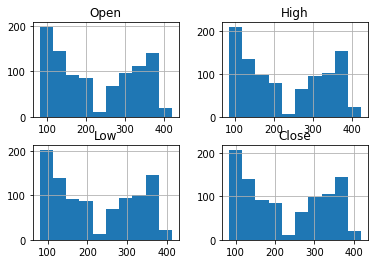

In [58]:
import matplotlib.pyplot as plt

data_used = data.iloc[:, 1:4]  # 개장가, 최고가, 최저가 추가
data_used["Close"] = data["Close"]  # 종가 추가
hist = data_used.hist()
plt.show()

## 넷플릭스 데이터셋 정의

In [59]:
import numpy as np
from torch.utils.data.dataset import Dataset

class Netflix(Dataset):  # 클래스 선언
    def __init__(self):
         # 데이터 읽기
          self.csv = pd.read_csv("/content/drive/MyDrive/rnn_train.csv")
        # 입력 데이터 정규화
          self.data = self.csv.iloc[:,1:4].values
          self.data = self.data /np.max(self.data)
        # 종가 데이터 정규화
          self.label = self.csv['Close'].values
          self.label = self.label/np.max(self.label)
    def __len__(self):

        return len(self.data) - 30

    def __getitem__(self, i):
        # 입력 데이터 30일치 읽기
        data = self.data[i:i+30]

        # 종가 데이터 30일치 읽기
        label = self.label[i+30]
        return data, label

## RNN 모델 정의

In [60]:
class RNN(nn.Module):
   def __init__(self):
       super(RNN, self).__init__()
       self.rnn = nn.RNN(input_size=3,hidden_size=8, num_layers=5, batch_first=True)

       # 주가를 예측하는 MLP층 정의
       self.fc1 = nn.Linear(in_features=240, out_features=64)
       self.fc2 = nn.Linear(in_features=64,out_features=1)
       self.relu = nn.ReLU()
       # 활성화 함수 정의
        
   def forward(self, x, h0):
       # RNN층의 출력
       x, h0 = self.rnn(x,h0)

       # MLP층의 입력으로 사용될 수 있도록 모양 변경
       x= torch.reshape(x,(x.shape[0],-1))

       # MLP 층을 이용해 종가를 예측
       x= self.fc1(x)
       x= self.relu(x)
       x= self.fc2(x)
      
       # 예측한 종가를 1차원 벡터로 표현
       x = torch.flatten(x)

       return x

In [61]:
model = RNN().to(device)  # 모델의 정의
dataset = Netflix()  # 데이터셋의 정의

In [62]:
loader = DataLoader(dataset, batch_size=32)  # 배치 크기를 32로 설정

In [63]:
optim = torch.optim.Adam(params=model.parameters(), lr=0.0001)

## 학습 루프 정의

In [64]:
import tqdm
for epoch in range(200):
   iterator = tqdm.tqdm(loader)
   for data, label in iterator:
       optim.zero_grad()
      
      # 초기 은닉 상태      
       h0 = torch.zeros(5, data.shape[0],8).to(device)

      # 모델의 예측값
       pred = model(data.type(torch.FloatTensor).to(device),h0)

       # 손실의 계산
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))
       loss.backward()  # 오차 역전파
       optim.step()  # 최적화 진행

       iterator.set_description(f"epoch{epoch} loss:{loss.item()}") #tqdm 결과출력

torch.save(model.state_dict(), "./rnn.pth")  # 모델 저장

epoch199 loss:0.0010146116837859154: 100%|██████████| 30/30 [00:00<00:00, 87.08it/s]


## 모델 성능 평가하기

In [65]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1)  # 예측값을 위한 데이터 로더

preds = []  # 예측값들을 저장하는 리스트
total_loss = 0

with torch.no_grad():
   # 모델의 가중치 불러오기
   model.load_state_dict(torch.load("rnn.pth",map_location=device))

   for data, label in loader:
       # 초기 은닉상태 정의
       h0 = torch.zeros(5,data.shape[0],8).to(device)
       # 모델의 예측값 출력
       pred = model(data.type(torch.FloatTensor).to(device), h0)
       preds.append(pred.item())  # 예측값을 리스트에 추가
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))  # 손실계산
       total_loss += loss/len(loader)  # 손실의 평균치 계산

total_loss.item()

0.0018458585254848003

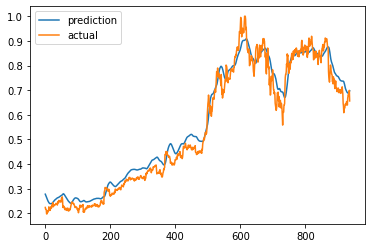

In [66]:
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()

# LSTM을 이용한 텍스트 생성

In [67]:
import string
import os
df = pd.read_csv("/content/drive/MyDrive/LSTM_data/ArticlesApril2017.csv")
print(df.columns)

Index(['abstract', 'articleID', 'articleWordCount', 'byline', 'documentType',
       'headline', 'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')


In [68]:
import numpy as np
import glob

from torch.utils.data.dataset import Dataset


class TextGeneration(Dataset):
    def clean_text(self, txt):
        # 모든 단어를 소문자로 바꾸고 특수문자를 제거
        txt = "".join(v for v in txt if v not in string.punctuation).lower()
        return txt
    def __init__(self):
        all_headlines = []

        # 모든 헤드라인의 텍스트를 불러옴
        for filename in glob.glob("/content/drive/MyDrive/LSTM_data/*.csv"):
          if "Articles" in filename:
            article_df = pd.read_csv(filename)
            all_headlines.extend(list(article_df.headline.values))
        # headline 중 unknown 값은 제거
        all_headlines = [h for h in all_headlines if h != "Unknown"]
        
        # 구두점 제거 및 전처리가 된 문장들을 리스트로 반환
        self.corpus = [self.clean_text(x) for x in all_headlines]
        self.BOW={}
        # 모든 문장의 단어를 추출해 고유번호 지정
        for line in self.corpus:
          for word in line.split():
            if word not in self.BOW.keys():
              self.BOW[word] = len(self.BOW.keys())

        # 모델의 입력으로 사용할 데이터
        self.data = self.generate_sequence(self.corpus)
    def generate_sequence(self, txt): # 텍스트를 시퀀스로 만들기
        seq = []

            # 단어 2개를 입력으로, 그다음 단어를 정답으로
        for line in txt:
          line = line.split()
          line_bow = [self.BOW[word] for word in line]
          
          data = [([line_bow[i],line_bow[i+1]],line_bow[i+2]) for i in range(len(line_bow)-2)]
          seq.extend(data)
        return seq
    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        data = np.array(self.data[i][0])  # 입력 데이터
        label = np.array(self.data[i][1]).astype(np.float32)  # 출력 데이터

        return data, label

In [69]:
class LSTM(nn.Module):
   def __init__(self, num_embeddings):
       super(LSTM, self).__init__()

       # 밀집표현을 위한 임베딩층
       self.embed = nn.Embedding(
           num_embeddings=num_embeddings, embedding_dim=16
       )
       

       
       # LSTM을 5개층을 쌓음
       self.lstm = nn.LSTM(
           input_size=16, 
           hidden_size=64,
           num_layers=5,
           batch_first=True)

       
       # 분류를 위한 MLP층
       self.fc1 = nn.Linear(128,num_embeddings)
       self.fc2 = nn.Linear(num_embeddings, num_embeddings)

       self.relu = nn.ReLU()


       # 활성화 함수


   def forward(self, x):

       x = self.embed(x)
       x,_ = self.lstm(x)
       x = torch.reshape(x,(x.shape[0],-1))
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
       return x

In [ ]:
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"


dataset = TextGeneration()  # 데이터셋 정의
model = LSTM(num_embeddings=len(dataset.BOW)).to(device)  # 모델 정의
loader = DataLoader(dataset, batch_size=64)
optim = Adam(model.parameters(), lr=0.001)

for epoch in range(200):
   iterator = tqdm.tqdm(loader)
   for data, label in iterator:
       # 기울기 초기화
       optim.zero_grad()

       # 모델의 예측값
       pred = model(torch.tensor(data, dtype=torch.long).to(device))

       # 정답 레이블은 long 텐서로 반환해야 함
       loss = nn.CrossEntropyLoss()(
           pred, torch.tensor(label, dtype=torch.long).to(device))
       
       # 오차 역전파
       loss.backward()
       optim.step()

       iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

torch.save(model.state_dict(), "lstm.pth")

  0%|          | 0/677 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
epoch24 loss:5.310359954833984:  67%|██████▋   | 454/677 [00:37<00:18, 12.21it/s]

In [ ]:
def generate(model, BOW, string="finding an ", strlen=10): #string: 입력할 문자 , strlen=문자열 길이
   device = "cuda" if torch.cuda.is_available() else "cpu"

   print(f"input word: {string}")

   with torch.no_grad():
       for p in range(strlen):
           # 입력 문장을 텐서로 변경
           words = torch.tensor(
               [BOW[w] for w in string.split()], dtype=torch.long
           ).to(device)
           # 모델 입력을 위한 배치 차원 추가
           input_tensor = torch.unsqueeze(words[-2:],dim=0)
           output = model(input_tensor)
           output_word= (torch.argmax(output).cpu().numpy())
           string += list(BOW.keys())[output_word]
           string += " "
   print(f"predicted sentence: {string}")

model.load_state_dict(torch.load("lstm.pth", map_location=device))
pred = generate(model, dataset.BOW)